# Describe PBR ($\textsf{ALL+}$ Superset) by Frequencies & Polarity

## Imports

In [1]:
from math import log1p, log2, log10, sqrt
from pathlib import Path
from sys import exit as sys_exit

# import dataframe_image as dfi
import matplotlib as mpl
import pandas as pd
from am_notebooks import *
from source.utils import HIT_TABLES_DIR, SANPI_HOME, timestamp_today
from source.utils.dataframes import NEG_REGEX, REGNOT
from source.utils.LexicalCategories import EXACTLY_RELEVANT_ADJ, SPECIAL_ADV

plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.family'] = ['cmr10', 'serif']
# plt.rcParams['font.sans-serif'] = ['cmss10' ,'Computer Modern Sans Serif'] #, 'Lucida Grande', 'Avant Garde']
# plt.rcParams['font.serif'] = 'cmr10'
# plt.rcParams['font.monospace'] = ['cmtt10', 'Computer Modern Typewriter']
# plt.rcParams['mathtext.fontset'] = 'cm'  # Use custom font for math text
# plt.rcParams['mathtext.rm'] = 'cmr10' # Replace with your desired font name
# plt.rcParams['mathtext.it'] = 'cmi10'  # Italic font
# plt.rcParams['mathtext.bf'] = 'cmb10'  # Bold font
plt.style.use('seaborn-v0_8-paper')

# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{fontspec}'
# plt.rcParams['axes.formatter.use_mathtext'] = False
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

RECOUNT_NEG = False

K = 20
BIGRAM_MIN = 100
ADV_MIN = 600
ADJ_MIN = 300
VERS_RESULTS_DIR = RESULT_DIR/'versatility'
confirm_dir(VERS_RESULTS_DIR)
FREQ_OUT_IMAGES = TEX_ASSETS.joinpath('images/ch2/freq-out')
confirm_dir(FREQ_OUT_IMAGES)
IMAGE_TYPE = 'pgf'

In [2]:
print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.serif'])
print(mpl.rcParams['font.monospace'])

['cmr10', 'serif']
['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']




## Collect Word and Bigram Counts

In [3]:
def set_outpath(dir_name, unit_name):
    return SANPI_HOME.joinpath(
        f'results/freq_out/{dir_name}/{unit_name}-counts_{dir_name}.{timestamp_today()}.csv')


def count_and_describe(values, name: str, dir_name: str = 'RBdirect'):
    counts = values.value_counts()
    outpath = set_outpath(dir_name, name)
    # x_neg.adv_form_lower.value_counts()
    counts.to_csv(outpath)
    print(f'💾 Saved {outpath.relative_to(SANPI_HOME)}')
    freq_stats = counts.to_frame(
        f'{name}_counts').describe().T.assign(
            unique=values.nunique()).round(4).convert_dtypes()
    # print(freq_stats.to_markdown(floatfmt=',.2f', intfmt=','))
    freq_stats.to_csv(outpath.with_name(
        outpath.name.replace('counts', 'freq-stats')))
    return counts, freq_stats


def seek_prior_counting(dir_name: str,
                        polarity: str) -> dict[pd.DataFrame]:
    adv_out = set_outpath(dir_name, f'{polarity[:3]}_adverb')
    adj_out = set_outpath(dir_name, f'{polarity[:3]}_adject')
    big_out = set_outpath(dir_name, f'{polarity[:3]}_bigram')
    outpath_dict = {'adv': adv_out, 'adj': adj_out, 'bigram': big_out}
    existing = {u: tuple(o.parent.glob(f'{Path(o.stem).stem}*csv'))
                for u, o in outpath_dict.items()}

    counts_dict = {}
    if all(existing.values()):
        for unit, path_tup in existing.items():
            col = f'{unit}_form_lower'.replace('bigram_form', 'bigram')
            loaded_counts = pd.read_csv(
                path_tup[0], engine='c', low_memory=True,
                index_col=col, keep_default_na=False,
                dtype={col: 'string', 'count': 'int'})
            print(f'Reading {unit.upper()} Counts from:\n  "{path_tup[0]}"')
            # ! Needed to deal with how pandas.read_csv treats the string "null"
            loaded_counts.index = loaded_counts.index.fillna('null')
            counts_dict[unit] = loaded_counts
    # neg_adj_counts = pd.read_csv(
    #     neg_adj_out, engine='c', low_memory=True, index_col='adj_form_lower')
    # neg_big_counts = pd.read_csv(
    #     neg_big_out, engine='c', low_memory=True, index_col='bigram_lower')
    return counts_dict


def count_hits(redo_neg=False):

    neg_ids = HIT_TABLES_DIR.joinpath('RBdirect/ALL_RBdirect_final-index.txt'
                                      ).read_text(encoding='utf8').splitlines()
    pos_ids = HIT_TABLES_DIR.joinpath('not-RBdirect/ALL_not-RBdirect_final-index.txt'
                                      ).read_text(encoding='utf8').splitlines()
    x_neg = pd.read_parquet(
        '/share/compling/data/sanpi/info/ALL_final-hits_basic.24-08-03.parq/category=RBdirect',
        engine='pyarrow',
        filters=[('hit_id', 'in', neg_ids)]
    )
    if 'hit_id' in x_neg.columns:
        x_neg = x_neg.set_index('hit_id')
    x_neg = x_neg.join(x_neg.all_forms_lower.str.extract(
        r'^(?P<trigger_lower>[^_]+)_(?P<adv_form_lower>[^_]+)_(?P<adj_form_lower>[^_]+)$')).convert_dtypes()
    adv_counts, neg_adv_stats = count_and_describe(
        x_neg.adv_form_lower, 'neg_adverb', 'RBdirect')
    adj_counts, neg_adj_stats = count_and_describe(
        x_neg.adj_form_lower, 'neg_adject', 'RBdirect')
    bigram_counts, neg_bigram_stats = count_and_describe(
        x_neg.bigram_lower, 'neg_bigram', 'RBdirect')

    trigger_counts, trigger_stats = count_and_describe(
        x_neg.trigger_lemma, 'trigger_lemma')
    trigger_form_counts, trigger_form_stats = count_and_describe(
        x_neg.trigger_lower, 'trigger_lower')

    print(pd.concat([neg_adv_stats, neg_adj_stats, neg_bigram_stats, trigger_stats,
                     trigger_form_stats]).convert_dtypes().to_markdown(floatfmt=',.2f', intfmt=','))
    if redo_neg:
        return
    # // x_neg = x_neg.join(x_neg.bigram_lower.str.extract(r'^(?P<adv_form_lower>[^_]+)_(?P<adj_form_lower>[^_]+)$')
    # //                    ).assign(polarity='neg').convert_dtypes()

    # // x_pos = catify(pd.read_parquet('',
    # //                                engine='pyarrow',
    # //                                columns=['adv_form_lower', 'adj_form_lower', 'hit_id']).set_index('hit_id').assign(polarity='pos'),
    # //                reverse=True)

    # // x_pos['bigram_lower'] = x_pos.adv_form_lower + '_' + x_pos.adj_form_lower
    pos_chunks = (
        pd.read_parquet(chunk,
                        engine='pyarrow',
                        columns=['bigram_lower', 'adv_form_lower',
                                 'adj_form_lower', 'token_str'])
        for chunk in Path(
            '/share/compling/data/sanpi/2_hit_tables/not-RBdirect/ALL_not-RBdirect_final.parq'
        ).rglob('group*.parquet'))
    x_pos = pd.concat(pos_chunks)

    pos_adv_counts, pos_adv_stats = count_and_describe(
        x_pos.adv_form_lower, 'pos_adverb', 'not-RBdirect')
    pos_adj_counts, pos_adj_stats = count_and_describe(
        x_pos.adj_form_lower, 'pos_adject', 'not-RBdirect')
    pos_bigram_counts, pos_bigram_stats = count_and_describe(
        x_pos.bigram_lower, 'pos_bigram', 'not-RBdirect')
    print(pd.concat([pos_adv_stats, pos_adj_stats, pos_bigram_stats,
                     ]).convert_dtypes().to_markdown(floatfmt=',.2f', intfmt=','))

    all_adv_counts, all_adv_stats = count_and_describe(
        pd.concat((x.adv_form_lower for x in [x_pos, x_neg])),
        'all_adverb', 'ANYdirect')
    all_adj_counts, all_adj_stats = count_and_describe(
        pd.concat((x.adj_form_lower for x in [x_pos, x_neg])),
        'all_adject', 'ANYdirect')
    all_bigram_counts, all_bigram_stats = count_and_describe(
        pd.concat((x.bigram_lower for x in [x_pos, x_neg])),
        'all_bigram', 'ANYdirect')

    print(pd.concat([all_adv_stats, all_adj_stats, all_bigram_stats,
                     ]).convert_dtypes().to_markdown(floatfmt=',.2f', intfmt=','))
    print(
        f'{pd.concat((x.token_str for x in [x_pos, x_neg])).nunique():,} total unique sentences in Polar Bigrams')


def combine_polarities(pos_counts, neg_counts, unit):
    pos_unit = pos_counts[unit]
    neg_unit = neg_counts[unit]
    unit_name = pos_unit.index.name
    all_unit = (
        pd.Series(pos_unit.index.tolist()+neg_unit.index.tolist()
                  ).drop_duplicates().to_frame(unit_name).set_index(unit_name)
        .join(pos_unit.rename(columns={'count': 'PosTokens'}))
        .join(neg_unit.rename(columns={'count': 'NegTokens'}))
        .fillna(0)
    )
    all_unit['AllTokens'] = (all_unit.PosTokens + all_unit.NegTokens)
    all_unit = all_unit.astype('int').sort_values('AllTokens', ascending=False)[
        ['AllTokens', 'PosTokens', 'NegTokens']]
    all_unit['%Neg'] = ((all_unit.NegTokens / all_unit.AllTokens)
                        * 100).astype('float64').round(3)
    all_unit['%Pos'] = ((all_unit.PosTokens / all_unit.AllTokens)
                        * 100).astype('float64').round(3)
    return all_unit


if RECOUNT_NEG:
    count_hits(redo_neg=True)

neg_counts = seek_prior_counting('RBdirect', 'neg')
pos_counts = seek_prior_counting('not-RBdirect', 'pos')

if not bool(neg_counts) and bool(pos_counts):
    count_hits()
    neg_counts = seek_prior_counting('RBdirect', 'neg')
    pos_counts = seek_prior_counting('not-RBdirect', 'pos')

Reading ADV Counts from:
  "/share/compling/projects/sanpi/results/freq_out/RBdirect/neg_adverb-counts_RBdirect.2024-09-14.csv"
Reading ADJ Counts from:
  "/share/compling/projects/sanpi/results/freq_out/RBdirect/neg_adject-counts_RBdirect.2024-09-14.csv"
Reading BIGRAM Counts from:
  "/share/compling/projects/sanpi/results/freq_out/RBdirect/neg_bigram-counts_RBdirect.2024-09-14.csv"
Reading ADV Counts from:
  "/share/compling/projects/sanpi/results/freq_out/not-RBdirect/pos_adverb-counts_not-RBdirect.2024-09-09.csv"
Reading ADJ Counts from:
  "/share/compling/projects/sanpi/results/freq_out/not-RBdirect/pos_adject-counts_not-RBdirect.2024-09-09.csv"
Reading BIGRAM Counts from:
  "/share/compling/projects/sanpi/results/freq_out/not-RBdirect/pos_bigram-counts_not-RBdirect.2024-09-09.csv"




### Adverb Counts

In [4]:
all_adv = combine_polarities(pos_counts, neg_counts, 'adv')
all_adv.index.name = 'adv'
print(f'> {len(all_adv):,} total unique adverbs')
nb_display(set_my_style(all_adv.filter(['null'], axis=0),
                        caption='Adverb, "null"'))
nb_display(set_my_style(all_adv.describe(),
                        caption='Stats for All Adverbs'))

> 56,449 total unique adverbs


,AllTokens,PosTokens,NegTokens,%Neg,%Pos
null,10,9,1,10.00,90.00


,AllTokens,PosTokens,NegTokens,%Neg,%Pos
count,"56,449.00","56,449.00","56,449.00","56,449.00","56,449.00"
mean,"1,274.80","1,218.58",56.22,2.70,97.30
std,"70,098.71","68,004.46","3,419.29",14.28,14.28
min,1.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,0.00,0.00,100.00
50%,1.00,1.00,0.00,0.00,100.00
75%,2.00,2.00,0.00,0.00,100.00
max,"9,220,012.00","9,030,189.00","531,731.00",100.00,100.00


In [5]:
top_adv_overall_f = all_adv.AllTokens.nlargest(10).to_frame('total observations')
top_adv_overall_f.index.name='adverb'
top_adv_overall_f.index = '<i>' + top_adv_overall_f.index + '</i>'
_sty = top_adv_overall_f.style.background_gradient('YlGnBu')
# save_latex_table(_sty, 
#                  caption='Top ADV frequencies in PBR', 
#                  latex_subdir='ch2/PBR-top-freq', latex_stem='adv-top-f-pbr', 
#                  default_SI=7.0, position='ht', verbose=True)



### Adjective Counts

In [6]:
all_adj = combine_polarities(pos_counts, neg_counts, 'adj')
all_adj.index.name = 'adj'
print(f'> {len(all_adj):,} total unique adjectives')
nb_display(set_my_style(all_adj.filter(['null'], axis=0),
                        caption='Adjective, "null"'))
nb_display(set_my_style(all_adv.describe(),
                        caption='Stats for All Adjectives'))

> 241,550 total unique adjectives


,AllTokens,PosTokens,NegTokens,%Neg,%Pos
null,659,647,12,1.82,98.18


,AllTokens,PosTokens,NegTokens,%Neg,%Pos
count,"56,449.00","56,449.00","56,449.00","56,449.00","56,449.00"
mean,"1,274.80","1,218.58",56.22,2.70,97.30
std,"70,098.71","68,004.46","3,419.29",14.28,14.28
min,1.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,0.00,0.00,100.00
50%,1.00,1.00,0.00,0.00,100.00
75%,2.00,2.00,0.00,0.00,100.00
max,"9,220,012.00","9,030,189.00","531,731.00",100.00,100.00


In [7]:
top_adj_overall_f = all_adj.AllTokens.nlargest(10).to_frame('total observations')
top_adj_overall_f.index.name='adjective'
top_adj_overall_f.index = '<i>' + top_adj_overall_f.index + '</i>'
_sty = top_adj_overall_f.style.background_gradient('YlGnBu')
# save_latex_table(_sty, 
#                  caption='Top ADJ frequencies in PBR', 
#                  latex_subdir='ch2/PBR-top-freq', latex_stem='adj-top-f-pbr', 
#                  default_SI=7.0, position='ht', verbose=True)

### Bigram Counts

In [8]:
all_bigram = combine_polarities(pos_counts, neg_counts, 'bigram')
all_bigram.index = all_bigram.index.str.replace('_', ' ')
nb_display(set_my_style(all_bigram.describe(),
           caption='Stats for All Bigrams'))

,AllTokens,PosTokens,NegTokens,%Neg,%Pos
count,"2,118,583.00","2,118,583.00","2,118,583.00","2,118,583.00","2,118,583.00"
mean,33.97,32.47,1.50,3.71,96.29
std,"1,546.11","1,516.32",88.58,16.76,16.76
min,1.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,0.00,0.00,100.00
50%,1.00,1.00,0.00,0.00,100.00
75%,3.00,3.00,0.00,0.00,100.00
max,"1,049,935.00","1,047,841.00","44,441.00",100.00,100.00


In [9]:
top_bigram_overall_f = all_bigram.AllTokens.nlargest(10).to_frame('total observations')
top_bigram_overall_f.index.name='bigram'
top_bigram_overall_f.index = '<i>' + top_bigram_overall_f.index + '</i>'
_sty = top_bigram_overall_f.style.background_gradient('YlGnBu')
# save_latex_table(_sty, 
#                  caption='Top Bigram frequencies in PBR', 
#                  latex_subdir='ch2/PBR-top-freq', latex_stem='bigr-top-f-pbr', 
#                  default_SI=7.0, position='ht', verbose=True)

## Plot `AllTokens` for each of the 3 units

In [10]:
def _set_plot_color(unit_name):
    return ('DarkBlue' if unit_name.startswith('adj') else (
        'DarkMagenta' if unit_name.startswith('adv') else 'Indigo'))

In [54]:
def plot_totals(_unit_counts=all_adj,
                unit_name='adjective',
                image_file_type=IMAGE_TYPE,
                plot_color=None,
                plot_kind='line',
                layout_str='constrained',
                size=(4,3.5),
                pad_inches=0.05):

    _N = _unit_counts.AllTokens.sum()
    unique_vals = len(_unit_counts)
    plot_color = plot_color or _set_plot_color(unit_name)
    unit_name = unit_name.lower()

    _unit_totals = pd.to_numeric(_unit_counts.sort_values(
        ['AllTokens'], ascending=False
    ).reset_index().filter(like='All').squeeze())
    _unit_totals.index = _unit_totals.index + \
        (1 if _unit_totals.index[0] == 0 else 0)
    unique_and_N_str = (f'${unique_vals:,}$ '
               + '\\textit{total unique '+unit_name+'s}'
               + f'\n$N={_N:,}$')
    # > cumulative sum of marginals
    # _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    # _fig = _unit_totals.cumsum().plot(layout=layout_str,
    #                                   figsize=size, cmap=cmap,
    #                                   title=f'Cumulative Sum of Tokens by {unit_name}\nN={_N:,}'.title(
    #                                   ), ylabel='cumulative sum of tokens',
    #                                   xlabel=f'sequential order of unique {unit_name}s\n({unique_vals:,} total unique)',
    #                                   legend=False
    #                                   )

    # plt.savefig(
    #     FREQ_OUT_IMAGES.joinpath(
    #         f'{unit_name[:(3 if unit_name.lower().startswith("a") else 4)]}'
    #         f'-cumsum_PBR_{timestamp_month()}.{image_file_type}'),
    #     dpi=300, bbox_inches='tight', pad_inches=pad_inches)
    # # plt.show()
    # plt.close()

    # new fig
    # > sequential raw f
    # _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    # _fig = _unit_totals.plot(layout=layout_str,
    #                          kind='line', cmap=cmap, legend=False, figsize=size,
    #                          xlabel=f'sequential order of unique {unit_name}s\n({unique_vals:,} total unique)',
    #                          ylabel='observed tokens', logy=False,
    #                          title=f'Increasing {unit_name} Marginal Frequencies\nN={_N:,}'.title(
    #                          )
    #                          )

    # plt.savefig(
    #     FREQ_OUT_IMAGES.joinpath(
    #         unit_name[:(3 if unit_name.lower().startswith("a") else 4)] +
    #         f'-sequential-f-raw_PBR_{timestamp_month()}.{image_file_type}'),
    #     dpi=300, bbox_inches='tight', pad_inches=pad_inches)
    # # plt.show()

    # plt.close()

    # * sequential log f
    #! new fig
    _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    axp = _unit_totals.to_frame('freq').reset_index().plot(
        layout=layout_str,
        kind=plot_kind,
        x='index', y='freq',
        color=plot_color,
        legend=False, grid=True,
        figsize=size,
        xlabel=(f'frequency rank of unique {unit_name}s (log)\n'
                + f''),
        ylabel='frequency (log)',
        loglog=True,
        title=(f'Decreasing {unit_name} Marginal Frequencies\n'.title()
               + unique_and_N_str)
    )
    # plt.tight_layout()
    # ax.yaxis.grid(True)  # Enable major grid lines
    # ax.yaxis.grid(True, which='minor')  # Enable minor grid lines
    axp.minorticks_on()  # Enable minor ticks on the y-axis

    # Optionally, you can customize the appearance of the grid lines
    axp.yaxis.grid(True, which='major', linestyle='-',
                  linewidth=0.25)  # Major grid line style
    axp.yaxis.grid(True, which='minor', linestyle=':',
                  linewidth=0.15)  # Minor grid line style
    
    # ax.xaxis.grid(True)  # Enable major grid lines
    # ax.xaxis.grid(True, which='minor')  # Enable minor grid lines

    # Optionally, you can customize the appearance of the grid lines
    axp.xaxis.grid(True, which='major', linestyle='-',
                  linewidth=0.25)  # Major grid line style
    axp.xaxis.grid(True, which='minor', linestyle=':',
                  linewidth=0.15)  # Minor grid line style
    
    plt.savefig(
        FREQ_OUT_IMAGES.joinpath(
            unit_name[:(3 if unit_name.lower().startswith("a") else 4)] +
            f'-sequential-f-logxy_PBR_{timestamp_month()}.{"png" if plot_kind == "scatter" else image_file_type}'),
        dpi=300, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()
    plt.close()

    # * Histograms

    #! new fig
    # > log unit counts -&- sqrt frequencies
    _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    axh = _unit_totals.apply(sqrt).plot(
        layout=layout_str,
        kind='hist', color=plot_color, legend=False, figsize=size,
        ylabel=f'\# unique {unit_name}s (log)',
        xlabel=r'$\sqrt{frequency}$',
        log=True, grid=True,
        # logx=True,
        #  bins=20,
        title=(f'Histogram of {unit_name.title()} Marginal Frequencies\n'
               + unique_and_N_str)
    )
    # plt.tight_layout()
    # > y axis grid lines
    # Enable both major and minor grid lines for the y-axis
    # ax.yaxis.grid(True)  # Enable major grid lines
    # ax.yaxis.grid(True, which='minor')  # Enable minor grid lines
    axh.minorticks_on()  # Enable minor ticks on the y-axis

    # customize the appearance of the grid lines
    axh.yaxis.grid(True, which='major', linestyle='-',
                  linewidth=0.25)  # Major grid line style
    axh.yaxis.grid(True, which='minor', linestyle=':',
                  linewidth=0.15)  # Minor grid line style
    # > x axis grid lines
    # ax.xaxis.grid(True)  # Enable major grid lines
    # ax.xaxis.grid(True, which='minor')  # Enable minor grid lines
    axh.xaxis.grid(True, which='major', linestyle='-',
                  linewidth=0.25)  # Major grid line style
    axh.xaxis.grid(True, which='minor', linestyle=':',
                  linewidth=0.15)  # Minor grid line style
    
    plt.savefig(
        FREQ_OUT_IMAGES.joinpath(
            unit_name[:(3 if unit_name.lower().startswith("a") else 4)] +
            f'-hist-logYsqrtX_PBR_{timestamp_month()}.{image_file_type}'),
        dpi=300, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()
    plt.close()

    # # > log counts (raw frequency)
    # #! new fig
    # _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    # _fig = _unit_totals.plot(
    #     layout=layout_str,
    #     kind='hist',
    #     color=plot_color,
    #     legend=False,
    #     figsize=size,
    #     ylabel=(f'\# unique {unit_name}s (log)\n'
    #             + f'${unique_vals:,}$ '+r'\textit{total unique}'),
    #     xlabel='observed frequency',
    #     log=True,
    #     # logx=True,
    #     bins=20,
    #     title=f'Histogram of {unit_name} Marginal Frequencies\n$N={_N:,}$'.title())
    # # ! #HACK
    # plt.savefig(
    #     FREQ_OUT_IMAGES.joinpath(
    #         unit_name[:(3 if unit_name.lower().startswith("a") else 4)] +
    #         f'-hist-logYrawX_PBR_{timestamp_month()}.{image_file_type}'),
    #     dpi=300, bbox_inches='tight', pad_inches=pad_inches)
    # plt.show()
    # plt.close()

    #! new fig
    # > raw values (no log scaling)
    # _fig = plt.figure(layout=layout_str, figsize=size, dpi=300)
    # _fig = _unit_totals.plot(layout=layout_str,
    #                          kind='hist', color=plot_color, legend=False, figsize=size,  # bins=20,
    #                          ylabel=f'unique {unit_name}s\n({unique_vals:,} total unique)',
    #                          xlabel='observed tokens',
    #                          title=f'Distribution of {unit_name} Marginal Frequencies\n$N={_N:,}$'.title())

    # plt.savefig(
    #     FREQ_OUT_IMAGES.joinpath(
    #         f'{unit_name[:(3 if unit_name.lower().startswith("a") else 4)]}'
    #         f'-hist_PBR_{timestamp_month()}.{image_file_type}'),
    #     dpi=300, bbox_inches='tight', pad_inches=pad_inches)
    # plt.show()
    # plt.close()



### Adverb Totals

<Figure size 1200x1050 with 0 Axes>

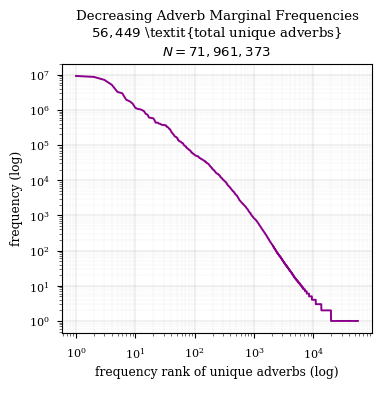

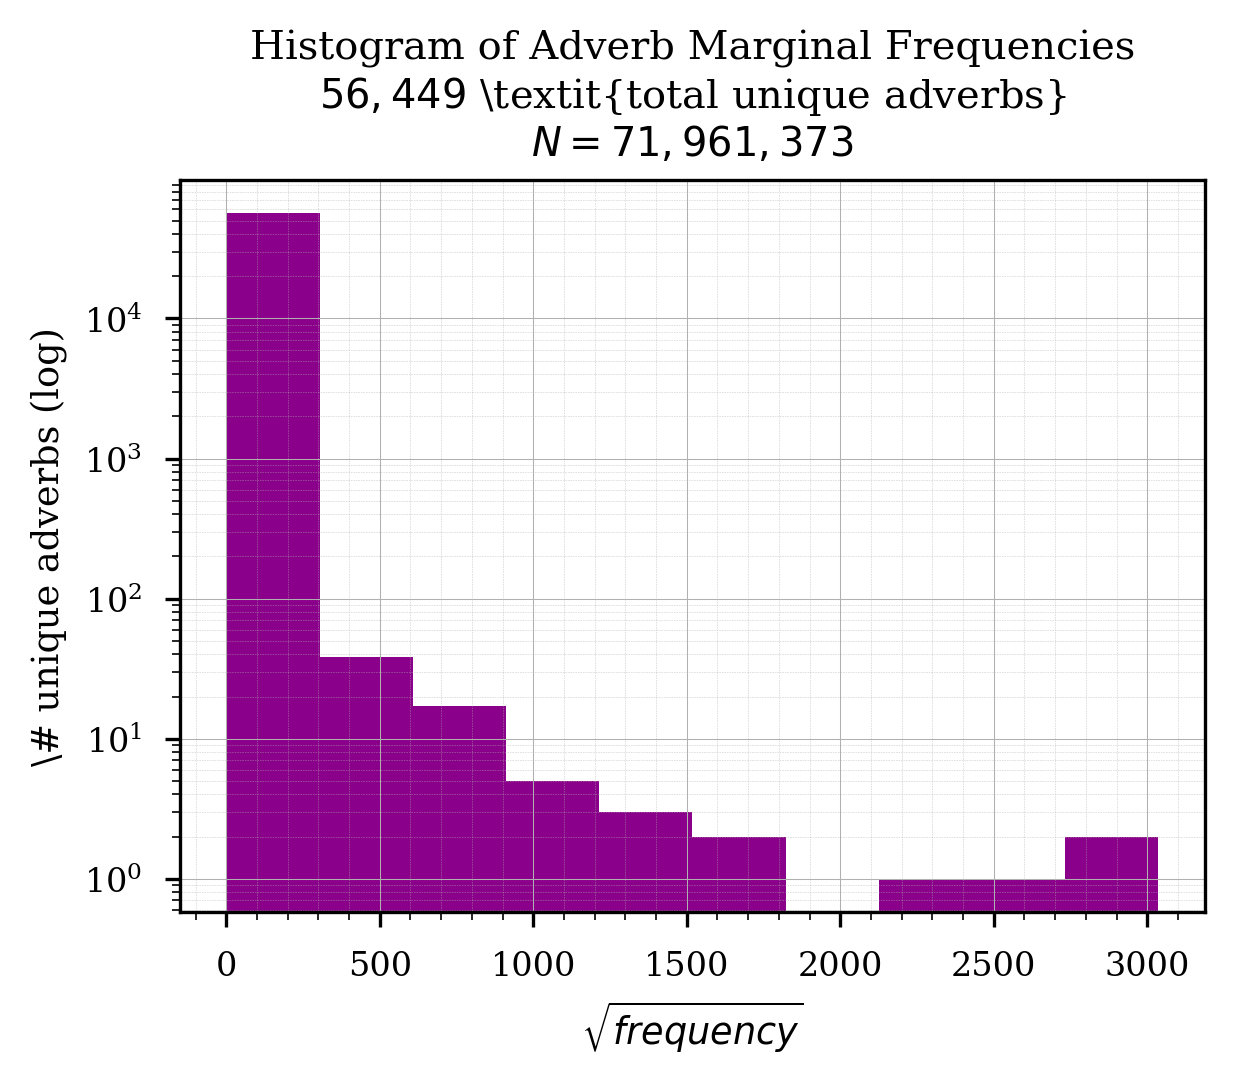

In [55]:
plot_totals(all_adv, 'adverb', plot_kind='line')
# plot_totals(all_adv, 'adverb', plot_kind='scatter')



### Adjective Totals

<Figure size 1200x1050 with 0 Axes>

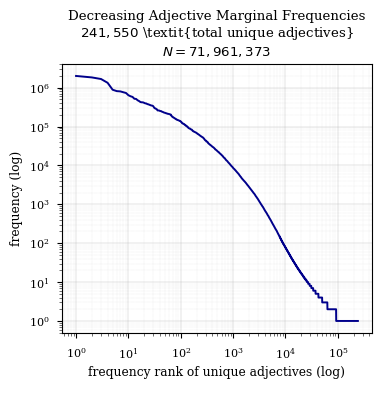

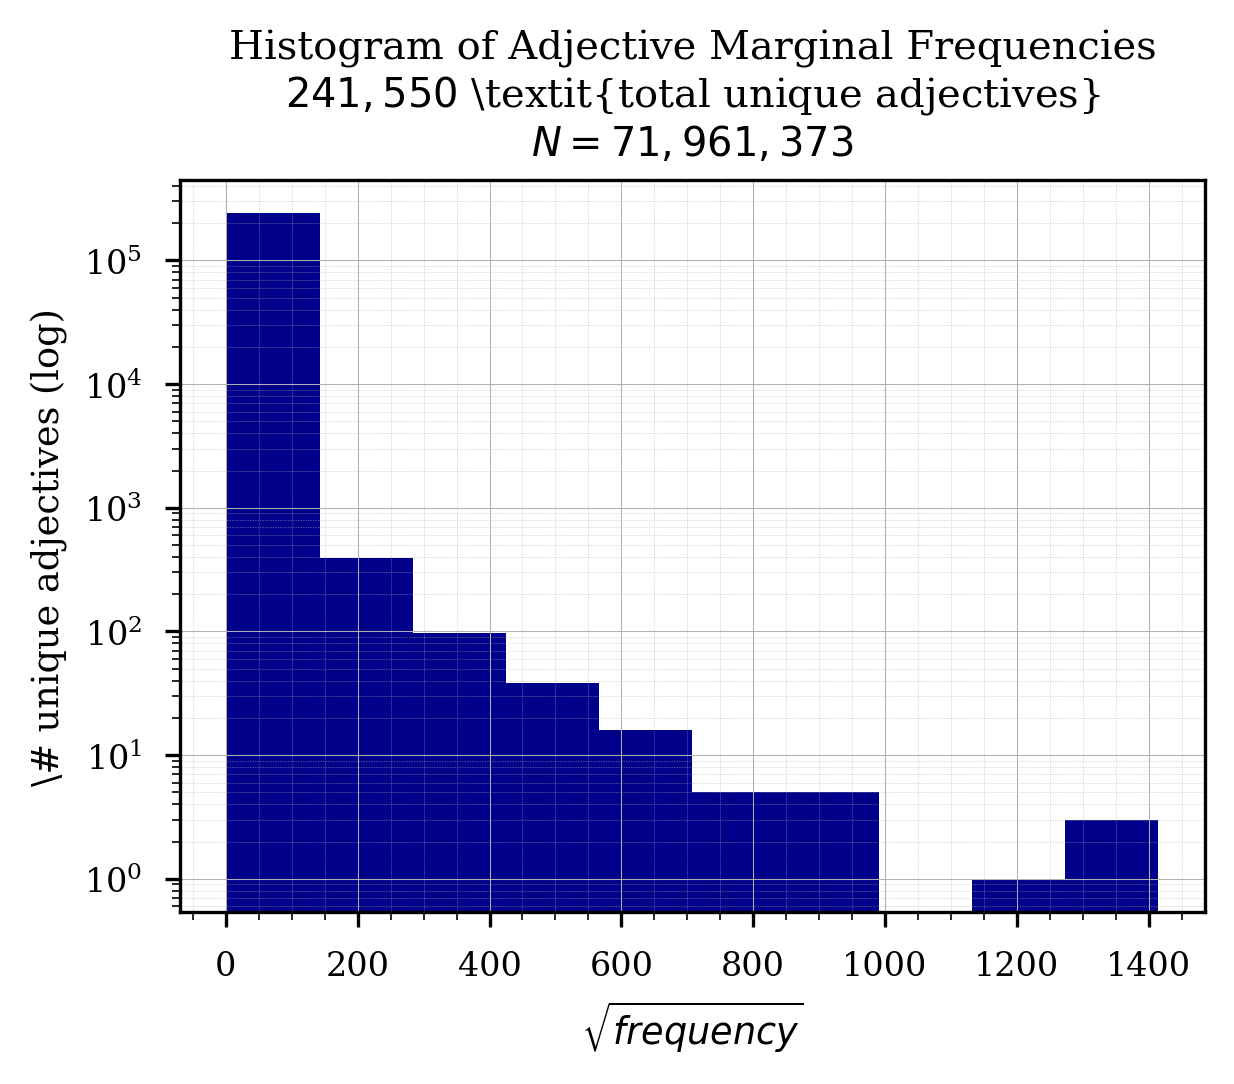

In [56]:
plot_totals(all_adj, 'adjective')
# plot_totals(all_adj, 'adjective', plot_kind='scatter')



### Bigram Totals

<Figure size 1200x1050 with 0 Axes>

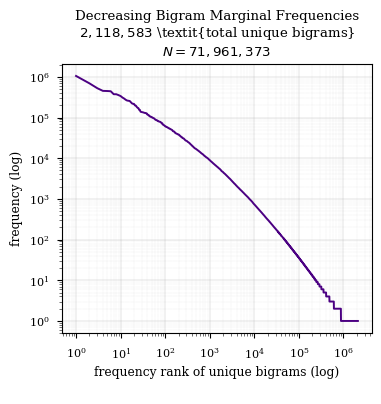

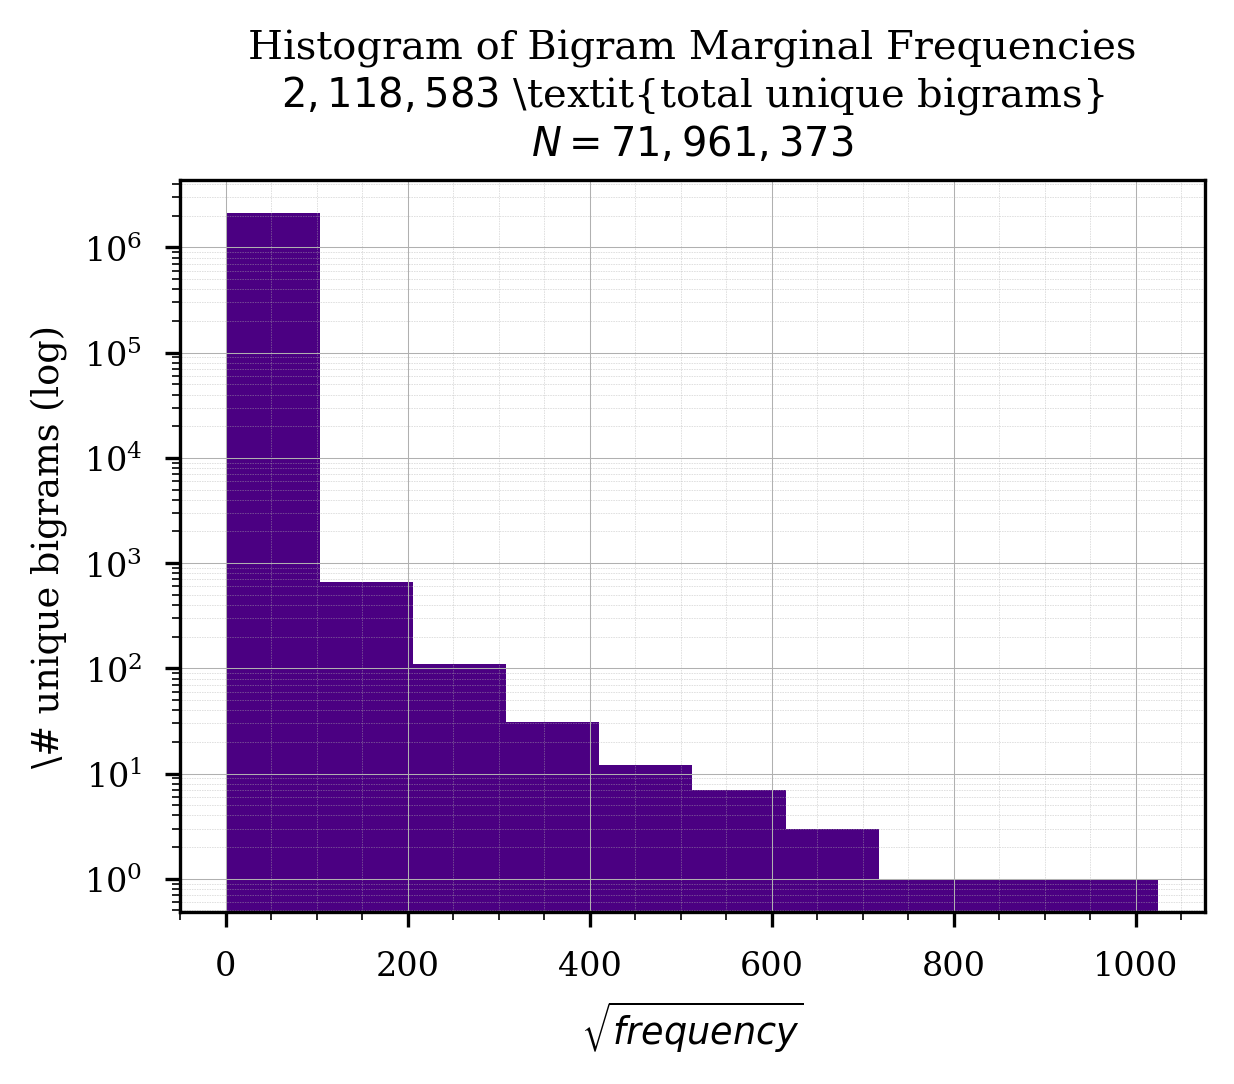

In [57]:
plot_totals(all_bigram, 'bigram', plot_color='Indigo')
# plot_totals(all_bigram, 'bigram', plot_color='Indigo', plot_kind='scatter')



### Violin? 🎻


In [ ]:
#  plt.violinplot([transform_counts(unit_freqs_df, method = 'log').AllTokens.reset_index(drop=True).squeeze()
#                  for unit_freqs_df in [all_adj, all_adv, all_bigram]],
#                 showmeans=True, showextrema=True, showmedians=True
#                 )
#  plt.xticks(ticks=[1,2,3], labels=[f'{unit}s'
#                     for  unit in ['adjective', 'adverb', 'bigram']])




### Box Plot of all 3

In [ ]:
unit_totals_dict = {'adverb': all_adv,
                    'adjective': all_adj,
                    'bigram': all_bigram}


def freq_box_plots(unit_f_dict):
    _fig = plt.figure(figsize=(3, 4), layout='constrained',
                      dpi=300, facecolor=None)
    box_data = [unit_freqs_df.AllTokens.squeeze()
                for unit_freqs_df in unit_f_dict.values()]
    plt.boxplot(
        box_data,
        tick_labels=[f'{unit}s'for unit in unit_f_dict.keys()],
        showmeans=True,
        meanprops={'marker': '^',
                   'markerfacecolor': 'Gold',
                   'markeredgecolor': 'black',
                   'markersize': 3},
        medianprops={'color': 'Teal', 'markerfacecolor': 'Teal'},
        flierprops={'marker': 'o',
                    'markerfacecolor': 'black',
                    'markeredgecolor': 'black',
                    'markersize': 2}

        # meanprops={'color': 'Salmon', 'markerfacecolor': 'Salmon', }, medianprops={'color': 'SlateBlue'},
        # showbox=True, showfliers=True
    )
    # means = [np.mean(d) for d in box_data]
    # medians = [np.median(d) for d in box_data]
    # maxs = [np.max(d) for d in box_data]

    # Add annotations
    for i, freqs in enumerate(box_data):
        f_info = freqs.describe()
        # > Annotate mean
        plt.text(i+1.045, f_info['mean']*1.5, f'mean: {round(f_info["mean"]):,.0f}',
                 fontsize=6,
                 ha='center', va='bottom',
                 backgroundcolor='Gold',
                 color='Black',
                 fontstyle='italic',
                 fontweight='normal')
        # > Annotate median
        # this_med = freqs.median()
        plt.text(i+1, f_info['50%'] * 0.6, f'median: {round(f_info["50%"]):.0f}',
                 fontsize=6, ha='center',
                 fontweight=400,
                 fontstyle='italic',
                 color='Teal',
                 #  backgroundcolor= 'Teal',
                 #  color='White',
                 va='bottom')
        # > Annotate max
        # this_max = freqs.max()
        most_freq = freqs[freqs == f_info['max']].index[0]
        break_str = "\n" if len(most_freq) > 5 else " "
        plt.text(i+1.1, f_info['max'] * 1.15, f'{f_info["max"]:,.0f}:{break_str}{most_freq}',
                 fontsize=6, ha='center',
                 fontweight=400,
                 fontstyle='italic',
                 color='DarkSlateBlue',
                 #  backgroundcolor= 'Teal',
                 #  color='White',
                 va='bottom')
    plt.yscale('log')
    plt.ylabel('marginal frequency (log)')
    # > y axis grid lines
    plt.grid(True, which='major',axis='y', linestyle='-',
                  linewidth=0.25)  # Major grid line style
    plt.grid(True, which='minor',axis='y', linestyle=':',
                  linewidth=0.15)  # Minor grid line style
    plt.savefig(
        FREQ_OUT_IMAGES.joinpath(
            f'AllTokens-x3-box-log_PBR_{timestamp_month()}.png'),
        dpi=300, bbox_inches='tight', pad_inches=0.05)
    # plt.savefig(
    #     FREQ_OUT_IMAGES.joinpath(
    #         f'AllTokens-x3-box-log_PBR_{timestamp_month()}.pdf'),
    #     dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    # ! This one was too complex to save as .pgf or .svg! It was massive.
    #// plt.savefig(
    #//     FREQ_OUT_IMAGES.joinpath(
    #//             f'AllTokens-x3-box-log_PBR_{timestamp_today()}.svg'),
    #//         dpi=300, bbox_inches='tight', pad_inches=0.05)
    
freq_box_plots(unit_totals_dict)



## Apply Color Gradient to Top Polar Values for each unit

In [ ]:
def get_top_dict(all_x_common, k=K):
    top_dict = dict.fromkeys(['neg', 'pos'])
    for pol in top_dict:
        top_w = all_x_common.nlargest(
            k, [f'%{pol.capitalize()}', 'AllTokens']).convert_dtypes().reset_index()
        top_w['#'] = range(1, k+1)
        top_dict[pol] = top_w.set_index(['#', all_x_common.index.name])
    return top_dict


def save_polar_tops(tops_dict, unit_name, f_min,
                    neg_cmap='PuBu',
                    pos_cmap='BuPu',
                    combined_cmap='PuBuGn'):
    for pole in ('neg', 'pos'):
        if pole == 'neg':
            longer = 'negative'
            cmap = neg_cmap
        else:
            longer = 'positive'
            cmap = pos_cmap
        save_latex_table(
            format_zeros(tops_dict[pole].style.background_gradient(cmap)),
            verbose=True,
            caption=(f'Top {K} {unit_name.capitalize()}s with '
                     + f'Highest <u>{longer.capitalize()} Polarity</u> Percentage ({f_min:,}+ tokens)'
                     + (f'<br/><i>Note: Explicitly negative {unit_name}s excluded</i>'
                        if pole == 'neg' else '')),
            latex_subdir=f'PBR_summary/{longer}',
            latex_stem=f'top{K}-{unit_name}-{pole}-pct=f{f_min}+',
            label=f'tab:top-{unit_name}-{pole}-pct')

    # > save combined table
    save_latex_table(
        format_zeros(pd.concat(tops_dict.values()
                               ).style.background_gradient(combined_cmap)),
        verbose=True,
        caption=(f'Top {K} {unit_name.capitalize()}s with '
                 + f'Highest <u>Negative & Positive Polarity</u> Percentage ({f_min:,}+ tokens)'
                 + f'<br/><i>Note: Explicitly negative {unit_name}s excluded</i>'),
        latex_subdir='PBR_summary',
        latex_stem=f'top{K}-{unit_name}-BOTH-pct=f{f_min}+',
        label=f'tab:top-{unit_name}-both-pct')



### Top Polar Relative *Bigram* Frequencies

In [ ]:
all_bigram_common = all_bigram.loc[
    (all_bigram.AllTokens >= BIGRAM_MIN)
    & ~(all_bigram.index.str.startswith(("not", "no ", "never", "n't"))), :]
bigram_tops = get_top_dict(all_bigram_common)
save_polar_tops(bigram_tops, 'bigram', BIGRAM_MIN)



### Top Polar Relative *Adverb* Frequencies

In [ ]:
all_adv_common = all_adv.loc[
    (all_adv.AllTokens >= ADV_MIN)
    & ~(all_adv.index.str.startswith(
        ("not", "never", "n't")))
    & (all_adv.index != 'no'), :]

adv_tops = get_top_dict(all_adv_common)
save_polar_tops(adv_tops, 'adverb', ADV_MIN,
                neg_cmap='GnBu', pos_cmap='BuGn', combined_cmap='YlGnBu')



### Top Polar Relative *Adjective* Frequencies

In [ ]:
all_adj_common = all_adj.loc[all_adj.AllTokens >= ADJ_MIN, :]

adj_tops = get_top_dict(all_adj_common)
save_polar_tops(adj_tops, 'adjective', ADJ_MIN,
                neg_cmap='PuRd', pos_cmap='RdPu', combined_cmap='RdPuBu')



##  Calculate Versatility



###  Split bigrams to calculate versatility

In [ ]:
def _split_bigrams(bigram_counts: pd.DataFrame,
                   strict: bool = False,
                   floor: int = 1):
    _bigram_counts = bigram_counts.copy()
    if strict:
        floor = floor if floor > 1 else 5
    if floor > 1:
        _bigram_counts = _bigram_counts.loc[_bigram_counts.AllTokens >= floor, :]
    # > This will catch both 'exactly_sure' and 'exactly sure' formatting of bigram strings
    adv_adj_str_df = _bigram_counts.index.str.extract(
        r'^(?P<adv>\S+)[ _](?P<adj>\S+)$')
    adv_adj_str_df.index.name = 'bigram'
    nunique_df = adv_adj_str_df.reset_index().nunique().to_frame(floor)
    nunique_df.columns.name = 'bigram f floor'
    return adv_adj_str_df, nunique_df



####  trivial = 1+

In [ ]:
bigram_split_any, trivial_bigram_unique_adx = _split_bigrams(all_bigram)
bigram_nunique_adx_df = trivial_bigram_unique_adx
nb_display(set_my_style(bigram_nunique_adx_df,
                        caption='Total Unique ADx appearing in <i>any</i> bigram (Trivial Unique)'
                        ).text_gradient('deep_waters', axis=None))



#### strict = 5+

In [ ]:
bigram_split_5, bigram_nunique_adx_5 = _split_bigrams(all_bigram, strict=True)
# bigram_split_5 = all_bigram.loc[all_bigram.AllTokens >= 5, :].index.str.extract(
#     r'^(?P<adv>[^_]+)_(?P<adj>[^_]+)$')
# // bigram_unique_adx_5 = bigram_split_5.nunique()
strict_bigram_nunique_adx = bigram_nunique_adx_5
bigram_nunique_adx_df = bigram_nunique_adx_df.join(
    strict_bigram_nunique_adx)
nb_display(set_my_style(strict_bigram_nunique_adx,
                        caption='Total Unique ADx appearing in bigrams with 5+ tokens (Strict Unique)'
                        ).text_gradient('deep_waters', axis=None))



#### Trivial and Strict together

In [ ]:
# sty = (set_my_style(
#     bigram_nunique_adx_df.copy().T.sort_index(),
#     caption='Total Unique ADx appearing in Bigram Sets, Strict(5) and Trivial (1)'
# )
#     # .bar(axis=None)
#     # #.text_gradient('inferno', axis=None, high=0.25)
#     .bar(
#         align='left',
#         cmap="blue_black_pink",
#         height=50, width=50,
#         props=(
#             "width: 120px; border-right: 1px solid black;"
#             " border-left: 1px solid black;")
# ))
# nb_display(sty)



#### Comparison of Unique ADx Set Cardinality for different bigram $f$ floors

In [ ]:
# for bfmin in [2, 3, 4, 10]:
#     __, bigram_nunique_adx_y = _split_bigrams(all_bigram, floor=bfmin)
#     bigram_nunique_adx_df = bigram_nunique_adx_df.join(bigram_nunique_adx_y)

# bigram_nunique_adx_df = bigram_nunique_adx_df.sort_index(axis=1)
# nb_display(bigram_nunique_adx_df)

In [ ]:
# sty = (set_my_style(
#     bigram_nunique_adx_df.copy().T.sort_index(),
#     caption='Comparison of Unique ADx Set Cardinality for different bigram frequency floors'
# )
#     # .bar(axis=None)
#     # #.text_gradient('inferno', axis=None, high=0.25)
#     .bar(
#         align='left',
#         cmap="blue_black_pink",
#         height=50, width=50,
#         props=(
#             "width: 120px; border-right: 1px solid black;"
#             " border-left: 1px solid black;")
# ))
# nb_display(sty)
# sty.to_html(LATEX_TABLES.joinpath(
#     'PBR_summary/versatility/uniqueADx_by_f-thresh.html'))
# print(f"--> table with databars saved as html:\n"
#       + f" {LATEX_TABLES.joinpath('PBR_summary/versatility/uniqueADx_by_f-thresh.html')}")

In [ ]:


# cm = 'gist_stern_r'
# save_latex_table(
#     bigram_nunique_adx_df.style
#     .text_gradient(cm, subset=bigram_nunique_adx_df.columns[1:], axis=1,
#                    low=0.2, high=0.05, vmin=0),

#     verbose=True,
#     caption='Unique Values by Minimum Frequency Floor',
#     label='tab:pbr-adx-unique-by-f-floor',
#     latex_path=TEX_ASSETS.joinpath(
#         'tables/PBR_summary/versatility/uniqueADx_by_f-thresh.tex'))

In [ ]:


# _fig = bigram_nunique_adx_df.plot(grid=True,
#                                   kind='bar', cmap='lisa_frank', logy=True, ylabel='\# Unique Values (log)',
#                                   title='Unique Values By Bigram Frequency Floor',
#                                   width=0.65, layout='constrained',
#                                   xlabel='lexical unit')
# plt.xticks(rotation=0)

# plt.savefig(
#     FREQ_OUT_IMAGES.joinpath(
#         f'nunique-ADx-by-freq-floor_PBR_{timestamp_today()}.{IMAGE_TYPE}'),
#     dpi=300, bbox_inches='tight', pad_inches=0.01)
# plt.show()
# plt.close()



### Counting Unique "Partners"

In [ ]:
def count_unique_partners(split_bigrams: pd.DataFrame,
                          unit: str,
                          nunique_df: int,
                          strict: bool = False):
    swap_adx = {'adv': 'adj', 'adj': 'adv'}
    kind_tag = "strict" if strict else "trivial"
    vers = split_bigrams.value_counts(unit).to_frame(
        f'{kind_tag}_{unit}_versatility')
    npossible = nunique_df.at[swap_adx[unit], 5 if strict else 1]
    print(f'{npossible:,}')
    vers[f'{kind_tag}_%of_{swap_adx[unit]}_forms'
         ] = (vers.squeeze()
              / npossible) * 100
    return vers  # .assign(unit=unit)[['unit'] + vers.columns.to_list()]

#### *Trivial* Versatility

In [ ]:
trivial_vers_adv = count_unique_partners(
    bigram_split_any, 'adv',  bigram_nunique_adx_df)
print(trivial_vers_adv.head().to_markdown(
    tablefmt='simple_outline', floatfmt='.2f', intfmt=','))

trivial_vers_adj = count_unique_partners(
    bigram_split_any, 'adj',  bigram_nunique_adx_df)
print(trivial_vers_adj.head().to_markdown(
    tablefmt='simple_outline', floatfmt='.2f', intfmt=','))

save_latex_table(pd.concat((trivial_vers_adv.describe().T,
                            trivial_vers_adj.describe().T)).convert_dtypes().style,
                 latex_subdir='PBR_summary/versatility', latex_stem='trivial_vers_adv',
                 label='tab:trivial-vers-adv', verbose=True)



#### *Strict* Versatility

In [ ]:
strict_vers_adv = count_unique_partners(
    bigram_split_5, 'adv',
    nunique_df=bigram_nunique_adx_df,
    strict=True)
print(strict_vers_adv.head().to_markdown(
    tablefmt='simple_outline', floatfmt='.2f', intfmt=','))

strict_vers_adj = count_unique_partners(
    bigram_split_5, 'adj',
    nunique_df=bigram_nunique_adx_df,
    strict=True)
print(strict_vers_adj.head().to_markdown(
    tablefmt='simple_outline', floatfmt='.2f', intfmt=','))

nb_show_table(pd.concat((strict_vers_adv.describe().T,
              strict_vers_adj.describe().T)).convert_dtypes())
save_latex_table(pd.concat((strict_vers_adv.describe().T,
                            strict_vers_adv.describe().T)).convert_dtypes().style,
                 latex_subdir='PBR_summary/versatility', latex_stem='strict_vers_adv',
                 label='tab:strict-vers-adv')

In [ ]:


strict_vers_adv.sort_index().join(all_adv.sort_index().filter(['AllTokens'])  # .apply(sqrt).to_frame('AllTokens_sqrt')
                                  ).plot(kind='scatter', loglog=True, color='DarkMagenta',
                                         x='strict_adv_versatility', y='AllTokens',
                                         title='ADV: Marginal Frequency (sqrt) by Strict Versatility')



#### Combined Descriptive Stats

In [ ]:
combined_vers_stats = pd.concat(
    (d.describe().T
     for d in [strict_vers_adv,
               trivial_vers_adv,
               strict_vers_adj,
               trivial_vers_adj]
     )
).round(1).convert_dtypes()
save_latex_table(combined_vers_stats.filter(like='vers', axis=0).T.convert_dtypes().style,
                 latex_subdir='PBR_summary/versatility', latex_stem='combined-vers-stats_values')
save_latex_table(combined_vers_stats.filter(like='%', axis=0).T.convert_dtypes().style,
                 latex_subdir='PBR_summary/versatility', latex_stem='combined-vers-stats_percents')



### *Adverbs*: Most Versatile

In [ ]:
adv_vers = strict_vers_adv.join(trivial_vers_adv).fillna(
    0).convert_dtypes().join(all_adv.filter(like='All'))
# adv_vers.to_csv(VERS_RESULTS_DIR / 'adverb_versatility.csv') #! already saved
nb_show_table(adv_vers.nlargest(30, strict_vers_adv.columns[0]))
save_latex_table(adv_vers.nlargest(30, strict_vers_adv.columns[0])
                 .style.background_gradient('BuPu'),
                 latex_stem='most-vers-adv',
                 label='tab:most-vers-adv',
                 latex_subdir='PBR_summary/versatility')
save_latex_table(adv_vers.filter(SPECIAL_ADV, axis=0)
                 .sort_values('strict_%of_adj_forms', ascending=False)
                 .style.background_gradient('BuPu'),
                 latex_stem='adv-of-interest-vers',
                 label='tab:adv-of-interest-vers',
                 latex_subdir='PBR_summary/versatility')



### *Adjectives*: Most Versatile

In [ ]:
adj_vers = strict_vers_adj.join(trivial_vers_adj).fillna(
    0).convert_dtypes().join(all_adj.filter(like='All'))
# adv_vers.to_csv(VERS_RESULTS_DIR / 'adjective_versatility.csv') #! already saved
nb_show_table(adj_vers.nlargest(10, strict_vers_adj.columns[0])
              )
save_latex_table(adj_vers.nlargest(30, strict_vers_adj.columns[0])
                 .style.background_gradient('BuGn'),
                 latex_stem='most-vers-adj',
                 label='tab:most-vers-adj',
                 latex_subdir='PBR_summary/versatility')

In [ ]:
def _get_versatile(all_pairs: pd.DataFrame,
                   substantial_pairs: pd.DataFrame,
                   k: int = None):
    if k == 0:
        k = len(substantial_pairs)
    k = k or K
    if all_pairs.filter(like='Vers').empty:
        all_pairs.columns = all_pairs.columns.to_series().apply(snake_to_camel).to_list()
        substantial_pairs.columns = substantial_pairs.columns.to_series().apply(
            snake_to_camel).to_list()
    most_versatile = substantial_pairs.copy().nlargest(
        k, substantial_pairs.columns[0])
    trivial_vers = all_pairs.filter(most_versatile.index, axis=0).squeeze()
    # most_versatile.loc[:, 'VersFacade'] = trivial_vers.filter(like='Vers').squeeze()
    vers_diff = trivial_vers.filter(like='Vers').squeeze(
    ) - most_versatile.filter(like='Vers').squeeze()
    perc_diff = trivial_vers.filter(like='%').squeeze(
    ) - most_versatile.filter(like='%').squeeze()
    most_versatile = most_versatile.join(trivial_vers)
    most_versatile.loc[:, 'VersDiff'] = vers_diff
    most_versatile.loc[:, 'PercDiff'] = perc_diff
    # nb_show_table(most_versatile.reset_index())
    return most_versatile


versatile_adj_K = _get_versatile(trivial_vers_adj, strict_vers_adj)

In [ ]:


versatile_adj_10 = _get_versatile(
    trivial_vers_adj, strict_vers_adj, 10)
vers_of_all_adj = _get_versatile(
    trivial_vers_adj, strict_vers_adj, 0)

In [ ]:
versatile_adj_10.style.background_gradient()

In [ ]:


versatile_adv_K = _get_versatile(
    trivial_vers_adv, strict_vers_adv)
versatile_adv_10 = _get_versatile(
    trivial_vers_adv, strict_vers_adv, 10)
vers_of_all_adv = _get_versatile(
    trivial_vers_adv, strict_vers_adv, 0)

In [ ]:
print(versatile_adv_10.assign(MarginalF=versatile_adv_10.index.to_series().map(all_adv.AllTokens)).style.to_latex())

In [ ]:


TARGET_ADV = tuple(pd.Series(
    [
        #   top superALL Negatively associated
        'necessarily', 'that', 'exactly', 'any', 'remotely', 'longer', 'ever',
        'immediately', 'yet', 'particularly', 'terribly',
        #   top superNEQ Positively associated
        'increasingly', 'relatively', 'almost', 'mostly', 'seemingly', 'fairly', 'pretty',
        'largely', 'rather', 'sometimes', 'also', 'now', 'probably', 'somewhat', 'potentially',

        'utterly', 'definitely', 'marginally', 'approximately', 'nearly',
        'albeit', 'quite', 'downright', 'absolutely',
        'kinda', 'sorta', 'entirely', 'especially', 'before',
        'only', 'just', 'extremely', 'slightly', 'precisely', 'accurately',
    ]
    + [
        'as', 'so', 'more', 'too', 'very', 'really',
        'always',  'completely', 'even', 'overly', 'less', 'most', 'all', 'totally', 'much',
        'actually', 'super', 'fully', 'merely',
        'also', 'often', 'still',
        'truly', 'highly', 'equally'
    ]  # + (
    # all_adv.loc[(all_adv.AllTokens > 500) & ~(all_adv.index.str.contains(
    #     NEG_REGEX)), :].nlargest(10, '%Neg').index.to_list()
    # + all_adv[all_adv.AllTokens > 500].nlargest(10, '%Pos').index.to_list())
    + sorted(SPECIAL_ADV)
).drop_duplicates().to_list())

print(f'"Adverbs of Interest" ({len(TARGET_ADV)})')
print(textwrap.wrap(repr(TARGET_ADV), 80))
# all_adv.filter(TARGET_ADV, axis=0)

In [ ]:


nb_display(set_my_style(format_zeros(
    all_bigram[~all_bigram.index.str.startswith(
        ("n't", 'not', 'no ', 'never'))]
    .filter(regex=r''.join(
        [f'|{a} ' for a in TARGET_ADV]), axis=0)
    .nlargest(K, ['%Neg', 'AllTokens']).style.background_gradient('PuBu'))
))

In [ ]:


nb_display(all_bigram.filter(regex=r''.join(
    [f'| {a}' for a in EXACTLY_RELEVANT_ADJ]), axis=0).nlargest(K, ['%Neg', 'AllTokens']).style.background_gradient('lavender_teal'))

In [ ]:


nb_display(all_bigram.filter(regex=r''.join(
    [f'|{a} ' for a in TARGET_ADV]), axis=0).nlargest(K, ['%Pos', 'AllTokens']).style.background_gradient())

In [ ]:


target_adv_vers = vers_of_all_adv.filter(TARGET_ADV, axis=0)
target_adv_vers.columns = target_adv_vers.columns.to_series().apply(
    snake_to_camel).to_list()
save_latex_table(format_zeros(target_adv_vers.nlargest(K, 'strictAdvVersatility')
                              # pd.concat(target_adv_vers.nlargest(15, '%Pos'),
                              #           target_adv_vers.nlargest(15, '%Neg'))
                              .style.background_gradient('pink_r')),
                 latex_subdir='adv-of-interest', verbose=True,
                 latex_stem='target-adv-most-vers',
                 label='tab:target-adv-most-vers'
                 )



## Calculate Polarity-Relative Versatility

In [ ]:
def show_most_versatile_by_pole(adx, _neg_counts, _pos_counts,
                                n_unique_df=bigram_nunique_adx_df,
                                unlimited: bool = False,
                                k=None):
    k = k or max(K, 30)
    target_adv_versatility = pd.DataFrame(index=TARGET_ADV)
    _vers_dict = {}
    for pole, polar_counts in [('Neg', _neg_counts), ('Pos', _pos_counts)]:
        print('\n### Processing', pole)
        pol_bigram_counts = polar_counts['bigram'].rename(
            columns={'count': 'AllTokens'})
        # pol_bigrams_5 = pol_bigram_counts.copy()[
        #     pol_bigram_counts.squeeze() >= 5]
        trivial_split, __ = _split_bigrams(pol_bigram_counts)
        strict_split, __ = _split_bigrams(pol_bigram_counts, strict=True)

        # neg_adv_unique_partners_5 = count_unique_partners(pol_bigrams_5, 'adv')
        # neg_adj_unique_partners_5 = count_unique_partners(pol_bigrams_5, 'adj')
        if adx == 'adv' and not unlimited:
            polar_target_adv_vers = count_unique_partners(
                strict_split, adx,
                n_unique_df, strict=True
            ).filter(TARGET_ADV, axis=0)

            polar_target_adv_vers.columns = [
                f'{pole}StrictVers', f'{pole}%ofStrict']

            target_adv_versatility = target_adv_versatility.join(
                polar_target_adv_vers)

        all_pairs = (count_unique_partners(
            trivial_split, adx,
            n_unique_df))
        all_pairs.columns = [f'{pole}TrivialVers', f'{pole}%ofTrivial']

        substantial_pairs = (count_unique_partners(
            strict_split, adx,
            n_unique_df, strict=True))
        substantial_pairs.columns = [f'{pole}StrictVers', f'{pole}%ofStrict']

        if unlimited:
            _vers_dict[pole] = _get_versatile(
                all_pairs=all_pairs,
                substantial_pairs=substantial_pairs,
                k=0)
        else:
            _vers_dict[pole] = _get_versatile(
                all_pairs=all_pairs,
                substantial_pairs=substantial_pairs,
                k=k)

        nb_display(set_my_style(_vers_dict[pole].head(8))
                   .background_gradient('PuBu' if pole == 'Pos' else 'PuRd'))

    pos_vers = _vers_dict['Pos']
    neg_vers = _vers_dict['Neg']

    if adx == 'adv' and not target_adv_versatility.empty:
        # nb_show_table(target_adv_versatility)
        return target_adv_versatility.fillna(0), pos_vers, neg_vers
    return None, pos_vers, neg_vers


def adjust_polar_vers(pol_vers_df=target_adv_vers,
                      overall_vers_for_unit=adv_vers):
    pol_vers_df.columns = pol_vers_df.columns.str.replace(
        'ofStrict', 'ofPossible').str.replace('Strict', '')
    pol_vers_df = pol_vers_df.assign(
        NegVersOdds=pol_vers_df.NegVers / pol_vers_df.PosVers,
        # PosMinusNegVers=pol_vers_df.PosVers - pol_vers_df.NegVers,
        # PosVersOdds=pol_vers_df.PosVers / pol_vers_df.NegVers,# > this is just the inverse of NegVersOdds and there are "inf" values
        AllVers=pol_vers_df.index.to_series().map(
            overall_vers_for_unit.filter(regex=r'tric.+ersatility').squeeze())
    )
    pol_vers_df = pol_vers_df.assign(
        # > this one *does* differ from the inverse of NegVersProb
        PosVersRatioAll=(pol_vers_df.PosVers / pol_vers_df.AllVers),
        NegVersRatioAll=(pol_vers_df.NegVers / pol_vers_df.AllVers),
    ).sort_values('NegVersOdds', ascending=False)

    return pol_vers_df


def save_colored_vers_tex(vers_df, category='adv-of-interest',
                          includes_f: bool = False,
                          label=None):
    label = label or f'PolarCompare-{category}-vers'
    _sty = (vers_df.convert_dtypes().style
            .background_gradient('bone_r', subset=vers_df.filter(like='All').columns)
            .background_gradient('PuRd', subset=vers_df.filter(like='Neg').columns)
            .background_gradient('PuBu', subset=vers_df.filter(like='Pos').columns)
            # ! Has to come last to overwrite the broader pattern
            .background_gradient('RdPuBu_r', subset=['NegVersOdds'])
            )
    if includes_f:
        label = label + '+f'
        # _sty = (_sty.
        #         .background_gradient('PuRd', subset=_neg_v_cols)
        #         .background_gradient('PuBu', subset=_pos_v_cols)
        #         .background_gradient('RdPuBu_r', subset=['NegVersOdds', 'NegVersProb'])
        #         .background_gradient('RdPuBu', subset=['PosVersOdds', 'PosVersProb']))
    save_latex_table(
        format_negatives(format_zeros(_sty)),
        verbose=True,
        latex_subdir=f'{category}/versatility',
        latex_stem=label,
        label=label
    )


def vers_freq_juxtaposition(pol_vers_df, freq_df):
    pol_vers_freq_info = (
        pol_vers_df
        .join(freq_df.filter(pol_vers_df.index, axis=0).filter(like='Tokens')))
    pol_vers_freq_info['Token%Neg'] = pol_vers_freq_info.index.to_series().map(
        freq_df['%Neg'])
    pol_vers_freq_info = pol_vers_freq_info.filter(
        ['AllVers',
         'PosVers', 'NegVers',
         'PosVersOdds', 'NegVersOdds',  # 'PosMinusNegVers',
         'PosVersRatioAll', 'NegVersRatioAll',
         #  'PosVersProb', 'NegVersProb',
         'AllTokens', 'PosTokens', 'NegTokens',  # '%Pos',
         'Token%Neg'])
    return pol_vers_freq_info



### Polarity Relative Adverb Versatility

In [ ]:
target_adv_vers, pos_adv_vers_top, neg_adv_vers_top = show_most_versatile_by_pole(
    'adv', neg_counts, pos_counts)

target_adv_vers = adjust_polar_vers(target_adv_vers, adv_vers)

[markdown]

#### Retrieve *all* versatility values

In [ ]:
__, pos_adv_vers_all, neg_adv_vers_all = show_most_versatile_by_pole(
    'adv', neg_counts, pos_counts, unlimited=True)



#### Save polarity-relative versatility values

In [ ]:
print('Polarity Relative Versatility Info saved as...')
for stem, adv_polar_vers_df in zip(
    ('target_adv_vers_info',
     'pos_adv_vers_info-all',
     'pos_adv_vers_info-top',
     'neg_adv_vers_info-all',
     'neg_adv_vers_info-top'),
    (target_adv_vers,
     pos_adv_vers_all,
     pos_adv_vers_top,
     neg_adv_vers_all,
     neg_adv_vers_top)
):
    _pol_vers_out_path = VERS_RESULTS_DIR.joinpath(stem).with_suffix('.csv')
    print(f'  {_pol_vers_out_path}')
    adv_polar_vers_df.to_csv(_pol_vers_out_path)



#### Colored $\LaTeX$ tables

In [ ]:
save_colored_vers_tex(target_adv_vers)
target_adv_info = vers_freq_juxtaposition(target_adv_vers, all_adv)
save_colored_vers_tex(target_adv_info, includes_f=True)


In [ ]:

save_latex_table(pos_adv_vers_top.filter(regex=r'Vers').nlargest(15, 'PosStrictVers').style.background_gradient('PuBuGn'),
                 latex_subdir='PBR_summary/versatility', latex_stem='pos-superset-most-vers-adv', verbose=True
                 )
save_latex_table(neg_adv_vers_top.filter(regex=r'Vers').nlargest(15, 'NegStrictVers').style.background_gradient('YlGnBu'),
                 latex_subdir='PBR_summary/versatility', latex_stem='neg-superset-most-vers-adv', verbose=True
                 )




### Adjective Polarity Relative Verstatility

In [ ]:
__, pos_adj_vers, neg_adj_vers = show_most_versatile_by_pole(
    'adj', neg_counts, pos_counts, unlimited=True)

print('Polarity Relative Versatility Info saved as...')
for stem, _adj_polar_vers_df in zip(
    (
        'pos_adj_vers_info-all',
        'neg_adj_vers_info-all'),
    (
        pos_adj_vers,
        neg_adj_vers),
):
    _pol_vers_out_path = VERS_RESULTS_DIR.joinpath(stem).with_suffix('.csv')
    print(f'  {_pol_vers_out_path}')
    _adj_polar_vers_df.to_csv(_pol_vers_out_path)

In [ ]:


combined_adj_polar_vers = pos_adj_vers.join(neg_adj_vers,
                                            lsuffix='Pos', rsuffix='Neg')
combined_adj_polar_vers.count()

In [ ]:


combined_adj_polar_vers = combined_adj_polar_vers.dropna()
combined_adj_polar_vers = adjust_polar_vers(combined_adj_polar_vers,
                                            adj_vers)
_pol_adj_vers_out_path = VERS_RESULTS_DIR.joinpath(
    'combined-polar-adj_versatility.csv')
print(f'  {_pol_adj_vers_out_path}')
combined_adj_polar_vers.to_csv(_pol_adj_vers_out_path)

In [ ]:


adv_vers_freq_juxta = vers_freq_juxtaposition(
    combined_adj_polar_vers, all_adj, )
adv_vers_freq_juxta = adv_vers_freq_juxta.loc[adv_vers_freq_juxta.AllTokens >= ADJ_MIN, :]

In [ ]:


adv_vfjuxta_top = pd.concat([adv_vers_freq_juxta.nlargest(K, 'NegVersOdds'),
                             adv_vers_freq_juxta.nsmallest(K, 'NegVersOdds')]).drop_duplicates()
save_colored_vers_tex(adv_vfjuxta_top,
                      'ADJ-Combined-tops', includes_f=True)

In [ ]:


immediately_bigrams = all_bigram.filter(like='immediately', axis=0)
immediately_margin = all_adv.loc['immediately', :].squeeze()
immediately_bigrams = immediately_bigrams.T.assign(
    immediately_MARGIN=immediately_margin).T
immediately_bigrams['%All_immediately'] = immediately_bigrams.AllTokens / \
    immediately_margin['AllTokens'] * 100
immediately_bigrams['%Neg_immediately'] = immediately_bigrams.NegTokens / \
    immediately_margin['NegTokens'] * 100
immediately_bigrams['%Pos_immediately'] = immediately_bigrams.PosTokens / \
    immediately_margin['PosTokens'] * 100
save_latex_table((immediately_bigrams
                 .loc[~immediately_bigrams.index.str.endswith('MARGIN'), :]
                 .nlargest(10, '%Neg_immediately')
                 .style.background_gradient('RdPuBu_r')),
                 latex_subdir='adv-of-interest', latex_stem='immediatly-nonversatile-ex_without-margin',
                 verbose=True
                 )

In [ ]:
nb_show_table(immediately_bigrams.nlargest(10, '%Neg'))
# # %%
# # super_adgrams['bigram_lower'] = (super_adgrams.adv_form_lower.astype('string') + '_' + super_adgrams.adj_form_lower).astype('string')
# print(f'{super_adgrams.bigram_lower.nunique():,} total unique bigram types (case-normalized forms)---attested combinations of',
#       f'{super_adgrams.adv_form_lower.nunique():,} adverb types and',
#       f'{super_adgrams.adj_form_lower.nunique():,} adjective types.')

# nb_show_table(super_adgrams.bigram_lower.value_counts().nlargest(
#     10).to_frame().reset_index())

# # %% [markdown]
# # _How many unique sentences?_

# # %%
# super_adgrams['sent_id'] = super_adgrams.index.str.split(':').str.get(0)

# # %%
# print(f'There are {super_adgrams.sent_id.nunique():,} total unique sentences')
# nb_show_table(super_adgrams.describe().T.convert_dtypes())